# Лабораторная работа №9 творческая!

# Выполнили Зимин Андрей Валерьевич и Жилин Андрей Игоревич

## Импорт библиотек

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

## Задание 1

Выполнить кластеризацию на каком-нибудь датасете

## Загрузка датасета

In [ ]:
df = pd.read_csv('data/iris.csv')
X = df.drop(columns=['variety'])

X_numpy = X.values[:, :2]
X_numpy[:5]

array([[5.1, 3.5],
       [4.9, 3. ],
       [4.7, 3.2],
       [4.6, 3.1],
       [5. , 3.6]])

Импортировали датасет, посмотрим на распределение

Text(0.5, 1.0, 'Диаграмма рассеяния')

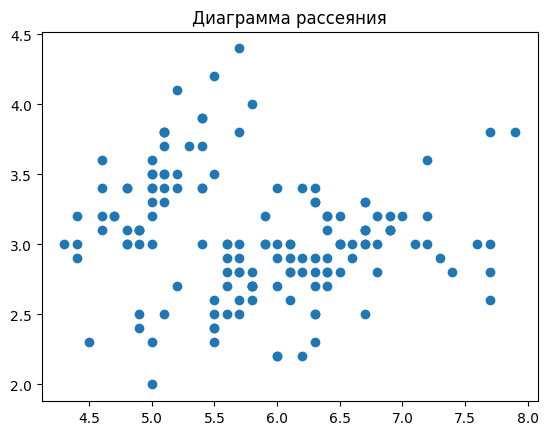

In [25]:
plt.scatter(X_numpy[:, 0], X_numpy[:, 1])
plt.title("Диаграмма рассеяния")

С кластерами тут сложно. Посмотрим что получится

In [9]:
class DBScan:
    def __init__(self, esp, min_pts, metric):
        self.esp = esp
        self.min_pts = min_pts
        self.metric = metric

    def fit_predict(self, X):
        # построим матрицу расстояний distance от каждого объекта до каждого
        n = X.shape[0]
        self.distance = np.zeros((n, n))
        for i in range(n-1):
            for j in range(i+1, n):
                value = self.metric(X[i, :], X[j, :])
                self.distance[i][j] = value
                self.distance[j][i] = value

        # определение корневых точек
        root = [sum(self.distance[i, :] < self.esp) >= self.min_pts for i in range(n)]
        # определение граничных точек
        border = [(not root[i]) and (True in [root[j] and (self.distance[i, j] < self.esp) for j in range(n)]) for i in range(n)]
        # определение выбросов
        noise = [not (root[i] or border[i]) for i in range(n)]
        #return root, border, noise

        # Создаем метки классов
        labels = -1 * np.ones(n, dtype=int)  # Изначально все метки -1 (шум)
        cluster_id = 0

        # Присваиваем метки классам
        for i in range(n):
            if root[i] and labels[i] == -1:  # Если это корневая точка и она еще не имеет метки
                labels[i] = cluster_id  # Присваиваем метку кластеру
                self._expand_cluster(i, labels, cluster_id)  # Расширяем кластер
                cluster_id += 1  # Увеличиваем идентификатор кластера для следующего кластера

        return labels

    def _expand_cluster(self, point_idx, labels, cluster_id):
        # Получаем индексы соседей для текущей точки
        neighbors = [j for j in range(len(labels)) if self.distance[point_idx, j] < self.esp]

        # Присваиваем метки всем соседям
        for neighbor_idx in neighbors:
            if labels[neighbor_idx] == -1:  # Если сосед еще не помечен
                labels[neighbor_idx] = cluster_id  # Присваиваем метку текущему кластеру
                self._expand_cluster(neighbor_idx, labels, cluster_id)  # Рекурсивно расширяем кластер

array([ 0,  0,  0,  0,  0, -1, -1,  0,  1,  0, -1, -1,  0,  1, -1, -1, -1,
        0, -1,  0,  2,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  2, -1, -1,
        0,  0,  2,  0,  1,  0,  0, -1, -1,  0,  0,  0,  0,  0, -1,  0,  3,
        3,  3,  4,  3,  4,  3,  5,  3, -1, -1,  3, -1,  3,  4,  3,  4,  4,
       -1,  4, -1,  3, -1,  3,  3,  3, -1,  3,  3,  4,  4,  4,  4,  3, -1,
       -1,  3, -1,  4,  4,  4,  3,  4,  5,  4,  4,  4,  3, -1,  4,  3,  4,
        6,  3,  3, -1,  5,  6, -1, -1,  3,  3,  3,  4,  4,  3,  3, -1, -1,
       -1,  3,  4, -1,  3,  3, -1,  3,  3,  3,  6,  6, -1,  3,  3,  3, -1,
        3,  3,  3,  3,  3,  3,  4,  3,  3,  3, -1,  3,  3,  3])

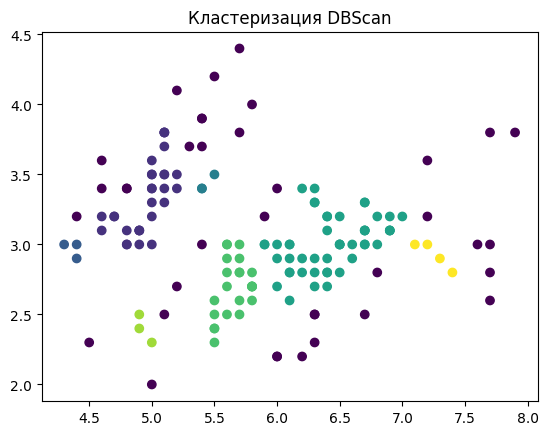

In [27]:
model = DBScan(esp=0.15, min_pts=3, metric=lambda x1, x2: sum((x1-x2)**2)**0.5)
labels = model.fit_predict(X_numpy)
plt.scatter(X_numpy[:, 0], X_numpy[:, 1], c=labels)
plt.title("Кластеризация DBScan")
labels

Определились некоторые классы. Выглядит неплохо. Также dbscan определил выбросы. Теперь посмотрим что скажет kmeans.

In [37]:
def kmeans(X, k, max_iters=100):
    # Шаг 1: Случайным образом инициализируем центры кластеров
    centers = X[np.random.choice(X.shape[0], k, replace=False)]
    
    for _ in range(max_iters):
        # Шаг 2: Присваиваем точки к ближайшему центру
        distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Шаг 3: Обновляем центры кластеров
        new_centers = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        
        if np.all(centers == new_centers):
            break
            
        centers = new_centers
        
    return labels, centers

k = 6
labels, centers = kmeans(X_numpy, k)
labels

array([5, 2, 2, 2, 5, 5, 2, 5, 2, 2, 5, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5,
       2, 5, 2, 2, 5, 5, 5, 2, 2, 5, 5, 5, 2, 2, 5, 2, 2, 5, 5, 2, 2, 5,
       5, 2, 5, 2, 5, 2, 1, 1, 1, 3, 1, 3, 1, 2, 1, 3, 3, 4, 3, 4, 3, 1,
       3, 3, 4, 3, 4, 4, 4, 4, 4, 1, 1, 1, 4, 3, 3, 3, 3, 4, 3, 4, 1, 4,
       3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 0, 4, 1, 0, 2, 0, 1, 0,
       1, 4, 1, 3, 3, 1, 1, 0, 0, 3, 1, 3, 0, 4, 1, 0, 4, 4, 4, 0, 0, 0,
       4, 4, 4, 0, 1, 1, 4, 1, 1, 1, 3, 1, 1, 1, 4, 1, 1, 4])

Text(0.5, 1.0, 'Кластеризация KMeans')

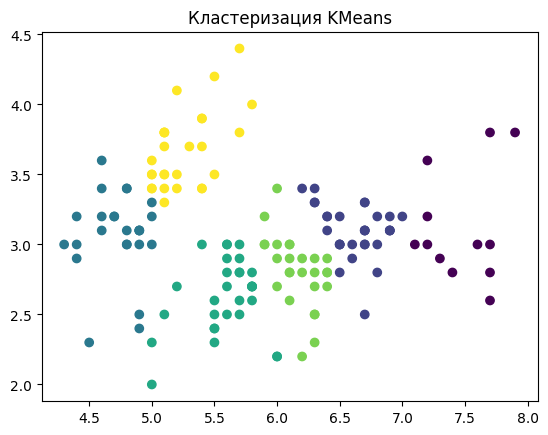

In [38]:
plt.scatter(X_numpy[:, 0], X_numpy[:, 1], c=labels)
plt.title("Кластеризация KMeans")

Получилось что-то достаточно похожее, однако kmeans не учитывает выбросы (из-за алгоритма, который лежит внутри)